In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read the raw data

In [53]:
df = pd.read_csv("/kaggle/input/uber-uncleaned-dataset/Uber Uncleaned Dataset")
df.head(7)

,id,timestamp,timezone,source,destination,cab_type,product_id,name,price,distance,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_line,Shared,5.0,0.44,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_premier,Lux,11.0,0.44,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft,Lyft,7.0,0.44,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_luxsuv,Lux Black XL,26.0,0.44,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_plus,Lyft XL,9.0,0.44,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800
5,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,1.545071e+09,America/New_York,Haymarket Square,North Station,Lyft,lyft_lux,Lux Black,16.5,0.44,...,0.0221,1545066000,34.19,1545048000,40.66,1545022800,27.39,1545044400,34.97,1545080400
6,462816a3-820d-408b-8549-0b39e82f65ac,1.543209e+09,America/New_York,Back Bay,Northeastern University,Lyft,lyft_plus,Lyft XL,10.5,1.08,...,0.1245,1543251600,40.67,1543233600,46.46,1543255200,37.45,1543291200,43.81,1543251600


In [ ]:
df.info()

In [ ]:
df.describe()

#### price, distance, temperature, windSpeed has some outliers as their max is significantly larger than 75th percentile value. These needs to be removed or replaced with some realistic values. Let's take each feature and work on its outlier and missing values.

In [ ]:
df.isnull().sum()

In [56]:
df.duplicated().sum()

0

### **Handling missing price values.**
#### The price column has the highest number of missing values, approximately 8% of the dataset. Since this is our target variable, it's crucial to investigate the nature of these missing entries before deciding how to handle them.
#### Let’s display only the rows where the price is missing to better understand any patterns or correlations in the missing data.

In [ ]:
df[df['price'].isna()]

In [ ]:
df[df['price'].isna()].describe()

### Now, we look at the rows where the price is present to contrast them with the missing-price entries.

In [ ]:
df[~df["price"].isna()]

### Upon inspection, we observe that for all rows where the price is missing, the corresponding name column is always "Taxi". In contrast, rows with a recorded price include a variety of ride types.

In [ ]:
df[df['price'].isna()]["name"].unique()

### We confirm that only "Taxi" appears in the name column when price is missing.

In [ ]:
df[~df['price'].isna()]["name"].unique()

### This shows the diversity of ride types when price is available — indicating that the missing data is specific to Taxi.
### The missing price values are not due to random data loss but are structurally missing only for Taxi rides. Since no pricing data is available for these rides, we can safely remove them from our modeling dataset.

In [10]:
df = df[~df["price"].isna()].reset_index(drop=True)

### **Handling outliers in price column**
75th percentile value is 22.5 USD while max is 6500 USD. All the rides of these dataset were inside Boston city. So, such high price will deteriorate the model performance. 
Min price is 2.5. Which shows no outlier in the lower spectrum.

In [ ]:
plt.figure(figsize=(13,12))
plt.subplot(2,2,1)
plt.boxplot(df["price"])
plt.title("Box Plot distribution for all price")

plt.subplot(2,2,2)
plt.boxplot(df[df["price"]<1000]["price"])
plt.title("Box Plot distribution for price<1000")

plt.subplot(2,2,3)
plt.boxplot(df[df["price"]<100]["price"])
plt.title("Box Plot distribution for price<100")

plt.subplot(2,2,4)
sns.histplot(df["price"], bins=100, kde=True)
# sns.histplot(df[df["price"]<100]["price"], bins=10, kde=True)
plt.title("Price Distribution (Histogram)")
plt.show()

In [ ]:
Q3 = df["price"].quantile(0.75)
Q1 = df["price"].quantile(0.25)

IQR = Q3-Q1
print(Q3 + 2 * IQR)

#### From above box plots and histogram distributions of price, we see that, the distribution is right skewed and price is highly concentrated below 100 and very less densely distributed above 100. 
#### And, Q3+2*IQR gives us 49.5 as outlier threshold.

In [ ]:
df[(df["price"]>50) & (df["price"]<100)]

In [ ]:
df[(df["price"]>50) & (df["price"]<100)]["name"].unique()

In [ ]:
df[df["price"]<50]["name"].unique()

#### Here, we see that, price from 50 to 100 is only for rides in big and luxurious car. So, these are not outliers. They have higher price for better services.

In [ ]:
len(df[df["price"]>100])/len(df["price"])*100

In [ ]:
df[df["price"]>100].head()

In [ ]:
df[df["price"]>100]["name"].unique()

#### Price above 100 represents only 0.5% of the data. These are not big luxurious cars only. Also, their distance is not high either. All the rides of this dataset is inside Boston city. So, such high prices is not justified and it needs to be replaced with better representatives.

In [ ]:
df["source"].unique()

In [ ]:
df["destination"].unique()

In [ ]:
df[["source","destination","name"]].drop_duplicates()

#### Pickup and dropoff locations are all in Boston and they are just 12 unique location. And, ride type also influences the price. So, we took unique combinations of these 3 feature. We will calculate the avg price of these unique combinations and impute that to the outliers.

In [11]:
price_threshold = 100

group_means = df[df["price"] <= price_threshold].groupby(
    ["source", "destination", "name"]
)["price"].mean()

df.loc[df["price"]>price_threshold, "price"] = df[df["price"]>price_threshold].apply(
    lambda row: group_means.get((row["source"], row["destination"], row["name"]), np.nan),
    axis=1
)

In [12]:
print("Null Values in price column: ", df["price"].isnull().sum())
df["price"].describe()

Null Values in price column:  0


count    637976.000000
mean         16.545163
std           9.322452
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64

Max is 97.5. So, outliers removed.

### **Handling Outliers and Missing Values in Distance Column**

#### The `distance` column contains approximately 1% missing values. We will impute the missing values using geographical distance between pickup and drop-off locations based on the Haversine formula.



In [20]:
print("Null Values: ",df["distance"].isnull().sum())
df["distance"].describe()

Null Values:  6368


count    631608.000000
mean          3.291970
std          17.591853
min           0.020000
25%           1.280000
50%           2.170000
75%           2.950000
max         746.000000
Name: distance, dtype: float64

In [12]:
df["distance"].quantile(0.99)

6.26

In [16]:
df[df["distance"]>6.26][["price","distance"]].head(7)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,price,distance
106,8.0,157.00
476,16.0,7.46
1005,45.5,431.00
1216,10.5,450.00
1334,10.5,266.00
1411,8.5,214.00
1412,10.0,272.00


In [17]:
df[df["distance"]>6.26]["price"].sum() / df[df["distance"]>6.26]["distance"].sum()

0.15640541273721986

In [18]:
df[df["distance"]<6.26]["price"].sum() / df[df["distance"]<6.26]["distance"].sum()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


7.620633066796025

A temp_df is created to store non null value of distance and visualize the data distribution.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


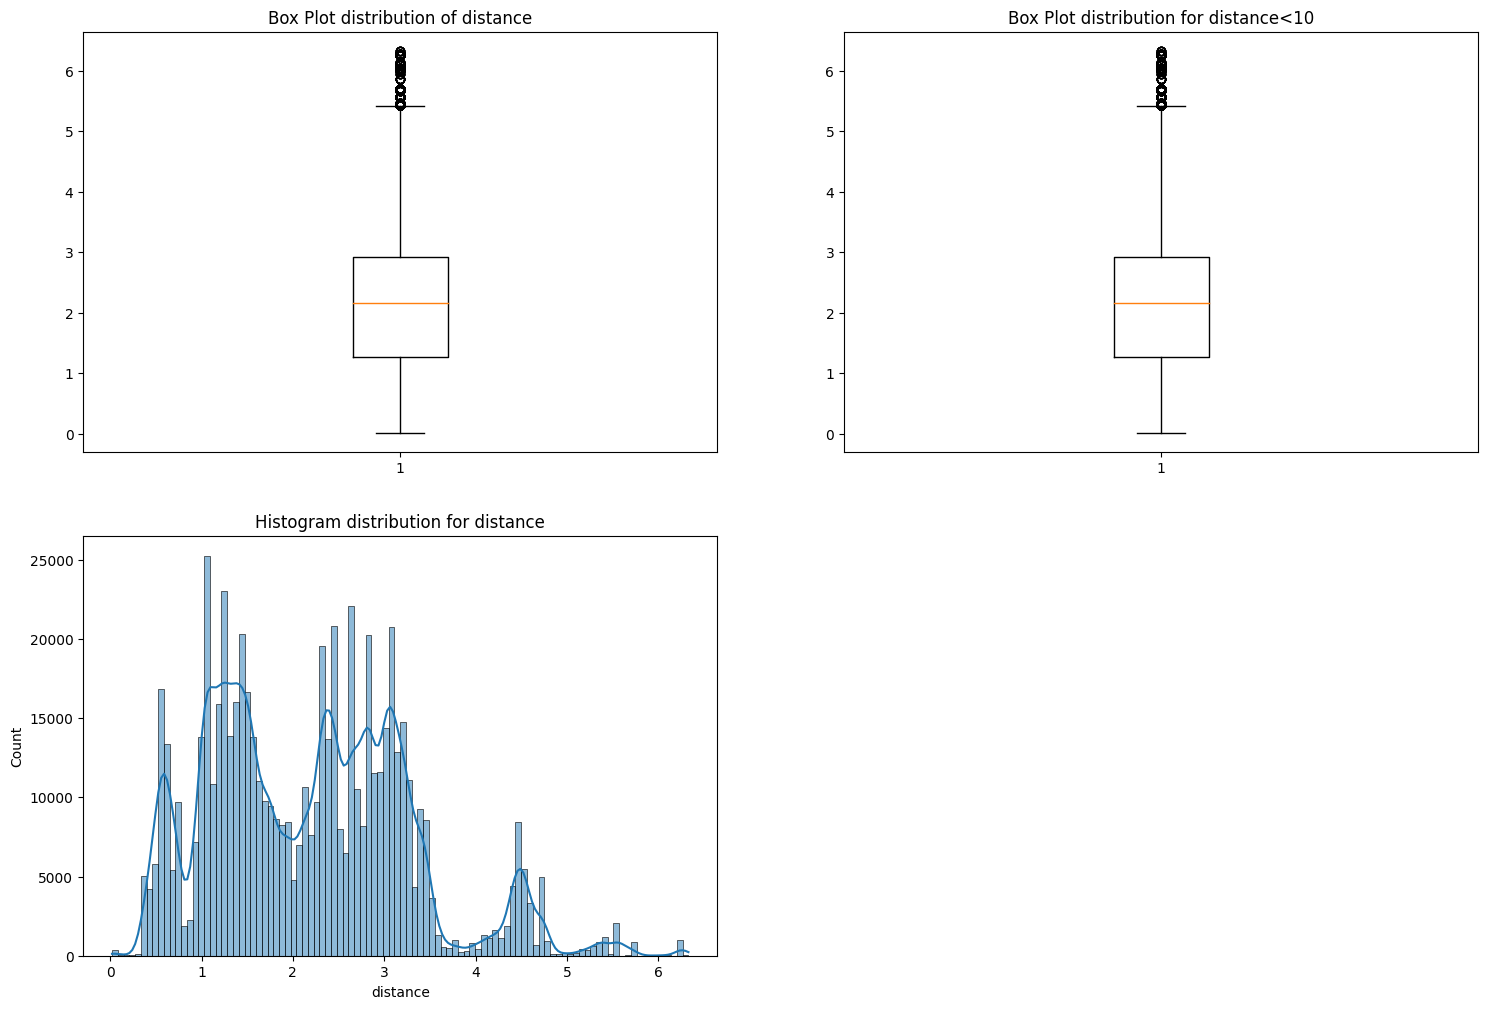

In [51]:
temp_df = df[~df["distance"].isna()]["distance"]

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.boxplot(temp_df)
plt.title("Box Plot distribution of distance")

plt.subplot(2,2,2)
plt.boxplot(temp_df[temp_df<10])
plt.title("Box Plot distribution for distance<10")

plt.subplot(2,2,3)
sns.histplot(temp_df, bins=100, kde=True)
plt.title("Histogram distribution for distance")
plt.show()

del temp_df

75th and 99th percentile data is 2.94 and 6.26 respectively. 746 being the max number clearly shows presence of outliers as all the rides was inside Boston city.
when distance is > 6.26(99th percentile value), price to distance ratio is 0.16, while ratio of 7.62 is seen in the opposite case. As, price didn't increase proportionally with distance, it tells us that those distances are outliers. And, the box plots also say the same.
We will replace both the outliers and missing value in same method. As, there are only 12 unique locations and 72 unique combinations of pickup location and dropoff location. We will calculate the avg distance of those unique combinations and impute the value to missing value and outliers.

In [40]:
df.loc[df["distance"]>6.82, "distance"] = np.nan

We replaced the outliers with NaN and now all the missing values will be replaced by avg distance of the pickup and dropoff location.

In [47]:
# Group mean distances by source and destination
group_means = df.groupby(["source", "destination"])["distance"].mean()

# Replace NaN distances with the group mean or overall mean if group not found
df["distance"] = df.apply( lambda row: group_means.get((row["source"], row["distance"]), df['distance'].mean()) if pd.isna(row["distance"]) else row["distance"], axis=1)

df["distance"].isnull().sum()

0

In [48]:
print(df[["price","distance"]].describe())
df[["price","distance"]].isnull().sum()

               price       distance
count  637976.000000  637976.000000
mean       16.545163       2.176572
std         9.322452       1.097781
min         2.500000       0.020000
25%         9.000000       1.270000
50%        13.500000       2.160000
75%        22.500000       2.930000
max        97.500000       6.330000


price       0
distance    0
dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


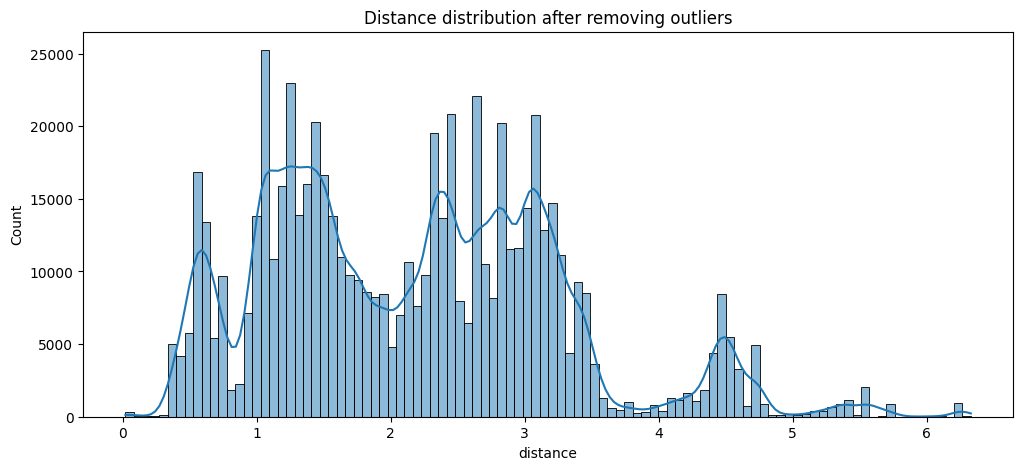

In [52]:
plt.figure(figsize=(12,5))
sns.histplot(df["distance"], bins=100, kde=True)
plt.title("Distance distribution after removing outliers")
plt.show()

Outliers and missing value for "price" and "distance" column has been handled.